In [120]:
import pandas as pd 
import numpy as np
import scipy.stats
import pylab 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from sklearn.metrics import r2_score
from pmdarima.arima import auto_arima
import seaborn as sns

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

### Import Digester 15 data

In [121]:
data15 = pd.read_csv("linearmoddataset.csv")
data15.head()

,BatchIndex,Delta,Damkohler,Sigma,CUM_Steam,Woodloading
0,0,-0.260848,0.123912,0.937022,25.2,108.666275
1,1,-0.344876,0.116629,1.033851,26.9,109.853065
2,2,-0.339656,0.115659,1.027957,27.9,112.921150
3,3,-0.317045,0.126365,0.993998,28.6,112.257874
4,4,-0.284570,0.122794,0.971008,25.3,112.399788


<Axes: >

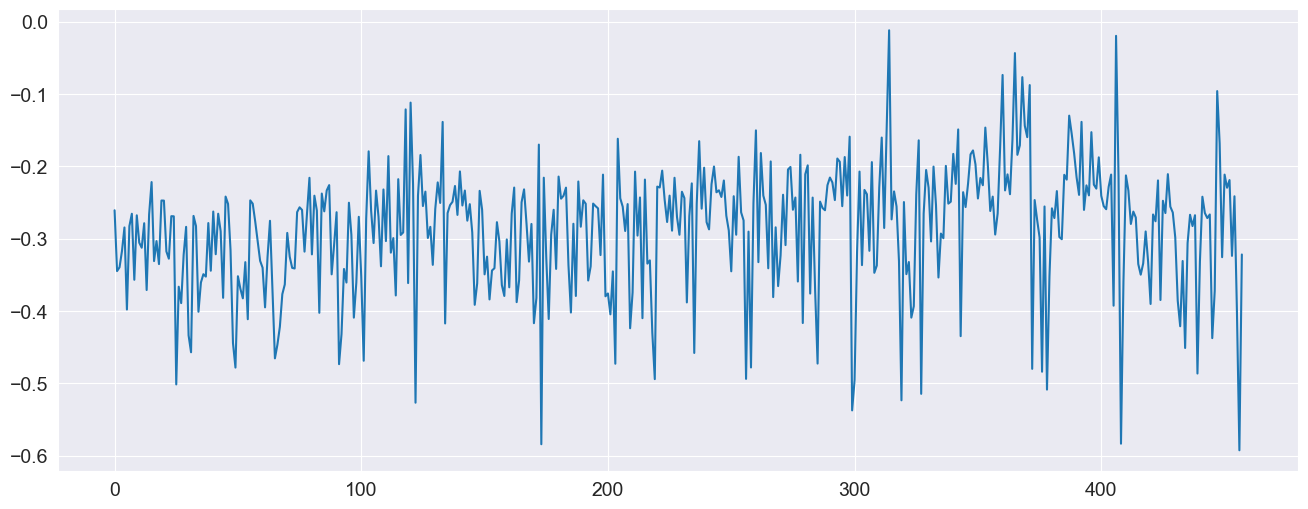

In [122]:
data15.Delta.plot()

<Axes: >

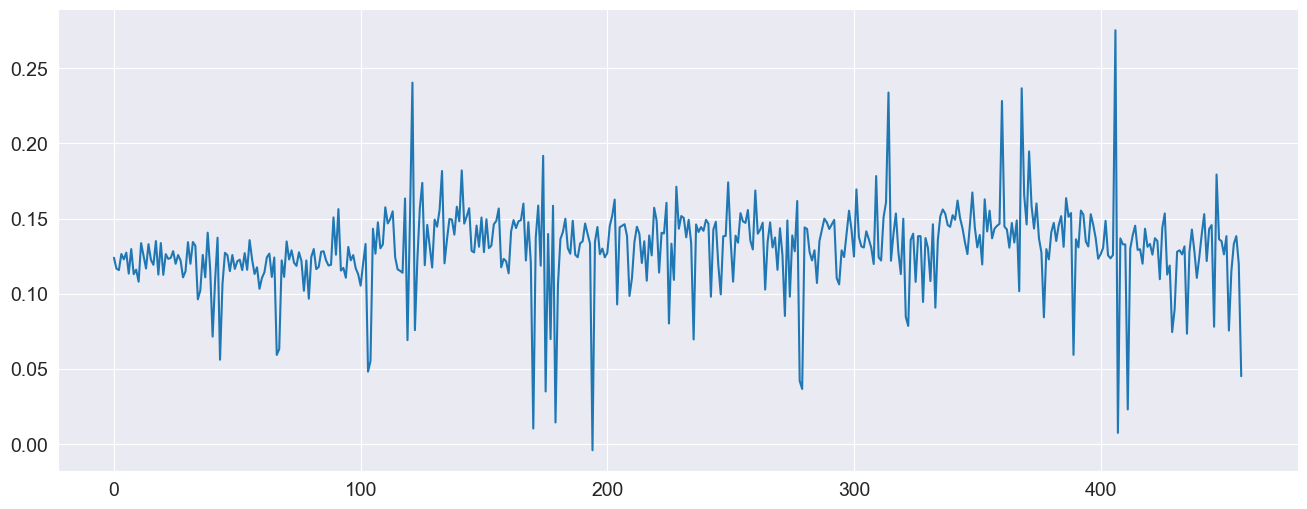

In [123]:
data15.Damkohler.plot()

<Axes: >

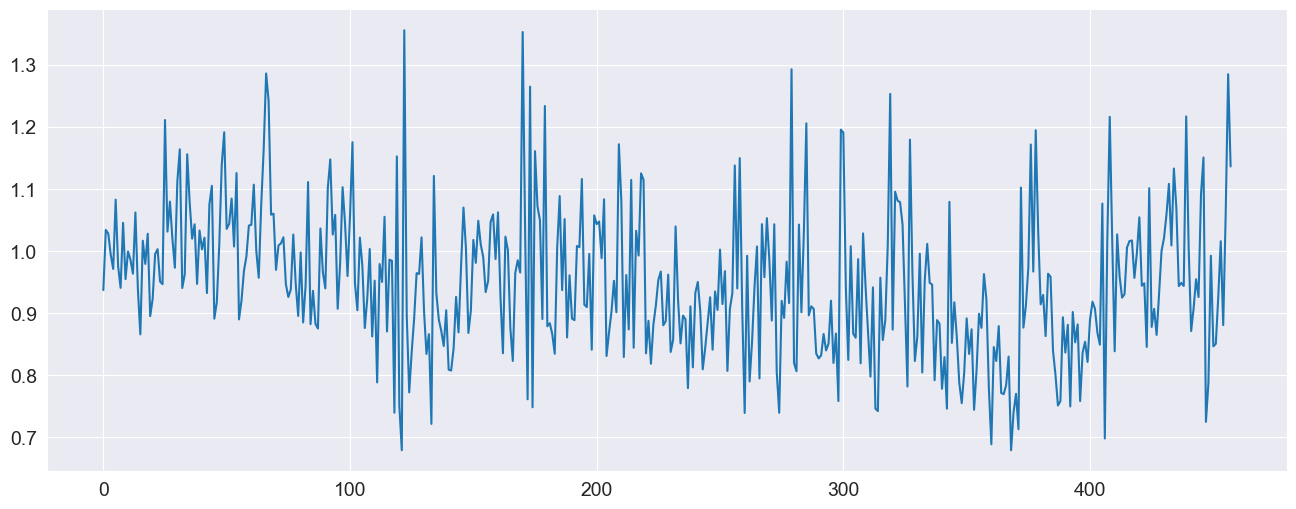

In [124]:
data15.Sigma.plot()

In [125]:
data15 = data15.drop(['Damkohler', 'CUM_Steam'], axis=1)

In [126]:
# Create a range of integers representing the time axis from 0 to 500
time_axis = range(0, len(data15))  # Assuming inclusive range from 0 to 500

# Multiply each integer by 60 to convert it to minutes
minutes = [t * 60 for t in time_axis]

# Convert the minutes to datetime format with 1-minute frequency
time_index = pd.date_range(start='2023-01-01', periods=len(minutes), freq='T')

# Assign the datetime index to the DataFrame
data15.index = time_index

# Drop the existing 'time' column
data15.drop(columns=['BatchIndex'], inplace=True)

# Rename the index to 'time'
data15.index.name = 'Time'

# Drop the existing 'Time' column if needed
data15_comp = data15.copy()

In [127]:
data15.head()

,Delta,Sigma,Woodloading
Time,,,
2023-01-01 00:00:00,-0.260848,0.937022,108.666275
2023-01-01 00:01:00,-0.344876,1.033851,109.853065
2023-01-01 00:02:00,-0.339656,1.027957,112.921150
2023-01-01 00:03:00,-0.317045,0.993998,112.257874
2023-01-01 00:04:00,-0.284570,0.971008,112.399788


In [128]:
data15_train = data15[:412]
data15_test = data15[412:]

In [129]:
data15_train.tail()

,Delta,Sigma,Woodloading
Time,,,
2023-01-01 06:47:00,-0.214339,1.014626,95.201584
2023-01-01 06:48:00,-0.583381,1.215810,95.179120
2023-01-01 06:49:00,-0.359145,1.018535,95.548090
2023-01-01 06:50:00,-0.212672,0.838498,95.176450
2023-01-01 06:51:00,-0.233596,1.026638,95.168365


In [130]:
data15_test.head

<bound method NDFrame.head of                         Delta     Sigma  Woodloading
Time                                                
2023-01-01 06:52:00 -0.279739  0.958988    95.179190
2023-01-01 06:53:00 -0.262664  0.924855    93.540530
2023-01-01 06:54:00 -0.270834  0.930323    96.737830
2023-01-01 06:55:00 -0.335122  1.005575    97.097946
2023-01-01 06:56:00 -0.349825  1.015849   119.443611
2023-01-01 06:57:00 -0.334237  1.016895   119.783524
2023-01-01 06:58:00 -0.290098  0.956581   113.750542
2023-01-01 06:59:00 -0.332132  0.996863   115.094070
2023-01-01 07:00:00 -0.390295  1.054142   115.286476
2023-01-01 07:01:00 -0.266612  0.943999   115.359390
2023-01-01 07:02:00 -0.276048  0.947911   100.718018
2023-01-01 07:03:00 -0.219576  0.845482   105.056221
2023-01-01 07:04:00 -0.384826  1.100989   102.277687
2023-01-01 07:05:00 -0.247729  0.877694    98.708435
2023-01-01 07:06:00 -0.264649  0.906773   106.690132
2023-01-01 07:07:00 -0.210916  0.864819   102.892616
2023-01-01 07:08

### Stationarity

In [131]:
# Sigma Stationarity
sts.adfuller(data15_comp.Sigma)

(-5.380304383765485,
 3.7252322125501973e-06,
 5,
 452,
 {'1%': -3.444900499925237,
  '5%': -2.8679556266351653,
  '10%': -2.570187288941969},
 -670.762052410354)

### ACF

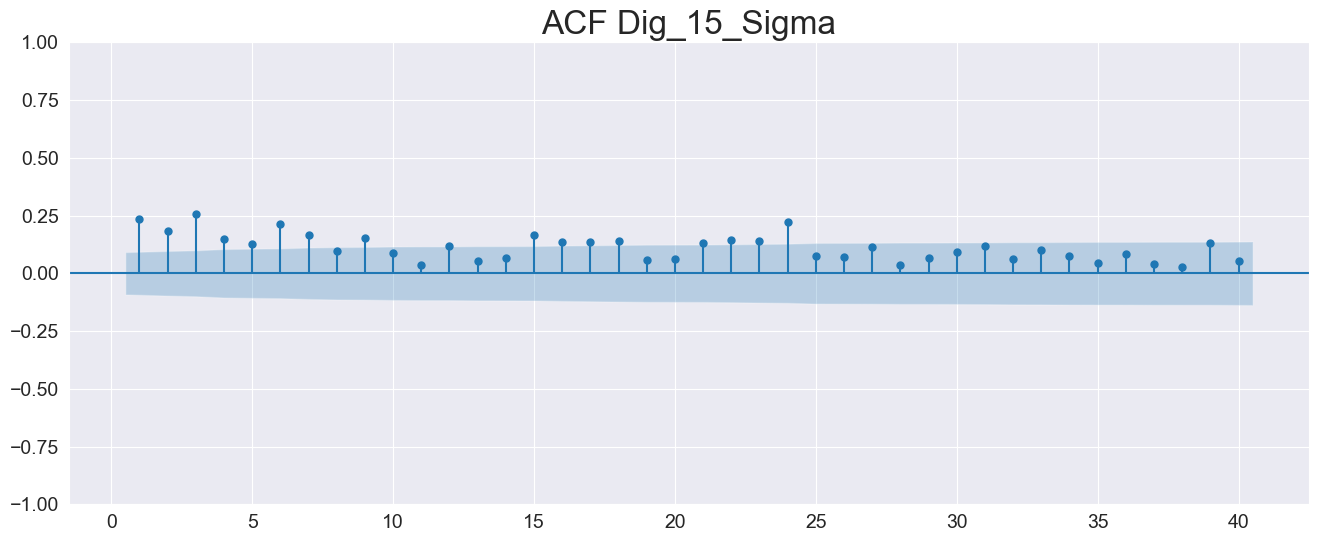

In [132]:
# Delta ACF
sgt.plot_acf(data15.Sigma, lags = 40, zero = False)
plt.title("ACF Dig_15_Sigma", size = 24)
plt.show()

### PACF

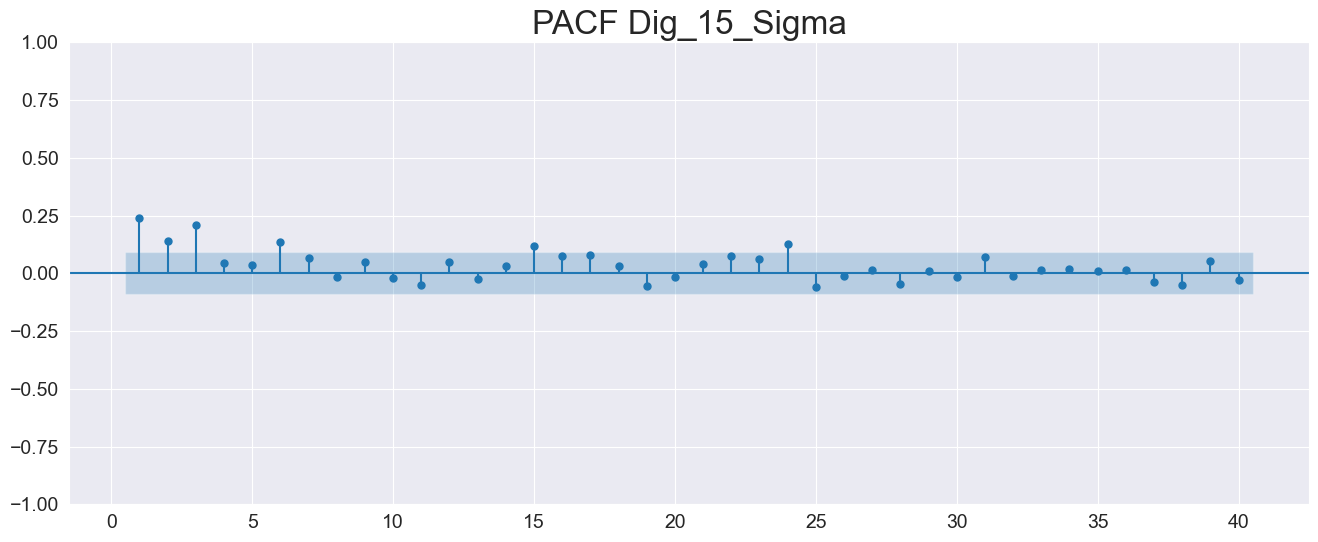

In [133]:
# Sigma PACF
sgt.plot_pacf(data15.Sigma, lags = 40, zero = False, method = ('ols'))
plt.title("PACF Dig_15_Sigma", size = 24)
plt.show()

In [134]:
#LLR Test
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)

    return p

In [135]:
# Model
model_params = ARIMA(data15_train.Sigma, order=(1, 1, 1))
results_arima = model_params.fit()
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sigma   No. Observations:                  412
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 321.331
Date:                Thu, 28 Mar 2024   AIC                           -636.662
Time:                        12:58:21   BIC                           -624.606
Sample:                    01-01-2023   HQIC                          -631.893
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0684      0.045      1.503      0.133      -0.021       0.158
ma.L1         -0.9350      0.019    -48.433      0.000      -0.973      -0.897
sigma2         0.0122      0.001     17.484      0.0

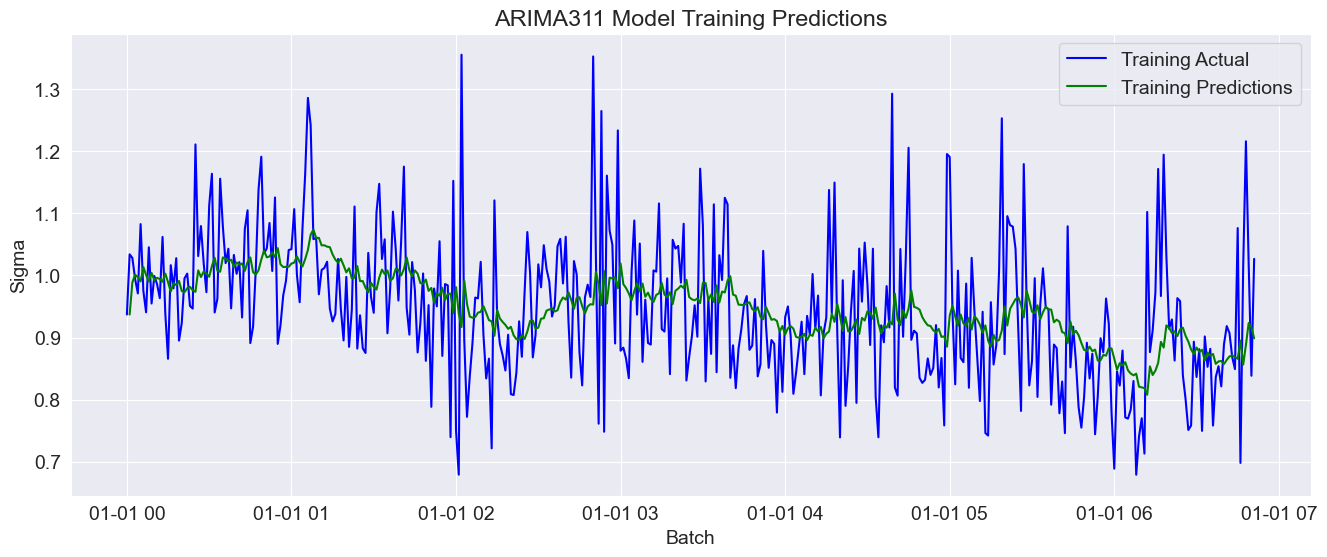

In [136]:
start_date = '2023-01-01 06:52:00'
end_date = '2023-01-01 07:37:00'

# Make predictions on training dataset
train_predictions = pd.DataFrame(results_arima.predict())
# print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
test_predictions = pd.DataFrame(results_arima.predict(start=start_date, end=end_date))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, data15_train['Sigma'], color='blue', label='Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], train_predictions['predicted_mean'].iloc[1:], color='green', label='Training Predictions')

# Add labels and legend
plt.title('ARIMA311 Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Sigma')
plt.legend()

# Show plot
plt.show()

### Training Performance

In [137]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_train['Sigma'], train_predictions['predicted_mean']))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_train['Sigma'], train_predictions['predicted_mean'])

print('rmse', rmse)
print('mae', mae)

rmse 0.11966609982583531
mae 0.0867782614529054


### Test Plots

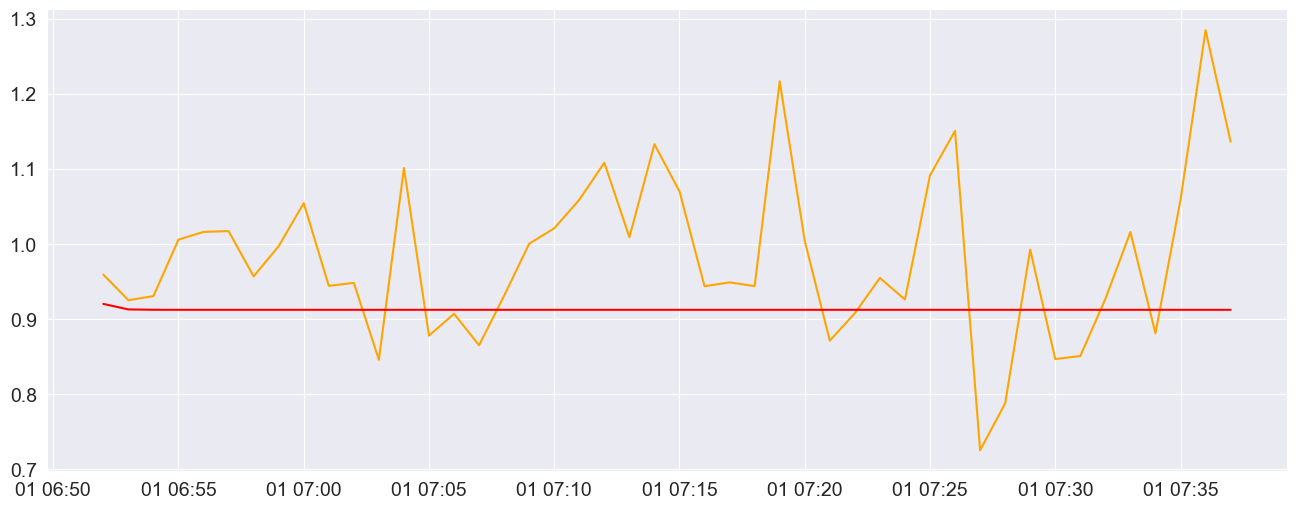

In [138]:
# Plot test data
plt.plot(data15_test.index, data15_test['Sigma'], color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, test_predictions['predicted_mean'], color='red', label='Forecast')

# Show plot
plt.show()

### Test Performance

In [139]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_test['Sigma'], test_predictions['predicted_mean']))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_test['Sigma'], test_predictions['predicted_mean'])

print('rmse', rmse)
print('mae', mae)

rmse 0.12807843349637607
mae 0.09809020669522954
